# Dependency

In [1]:
import h5py
import os
import pickle

from tqdm import tqdm
from time import gmtime, strftime
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

import numpy as np
import math

from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

import tensorflow as tf
from tensorflow.keras import layers,Model



from sklearn.model_selection import KFold

import gc

import time
from sklearn.model_selection import KFold

import import_test_die as load_data


2025-03-12 11:49:33.201249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-12 11:49:33.268999: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 11:49:33.575979: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/b1607/anaconda3/envs/tf/lib/
2025-03-12 11:49:33.576015: W tensorflow/compiler/xla/stream_e

# PARAM

In [2]:
DATA_LABEL=load_data.data_label()


WINDOW=6
MAXSEQ = WINDOW*2+1
DATASET="ATP_549"
DATA_TYPE = "rag_prottrans"

NUM_FEATURE = 1024

NUM_FILTER = 256
NUM_HIDDEN = 1000
BATCH_SIZE  = 1024
DROP = 0.0
WINDOW_SIZES = [6,8,10]

NUM_CLASSES = 2
CLASS_NAMES = ['Negative','Positive']

EPOCHS      = 3

K_Fold = 5
VALIDATION_MODE="cross"
#"independent" "cross"


In [3]:
"----------------------------------------------------------------------------------------------------"
# model fit batch funtion
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, labels, batch_size):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.data))

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = [self.data[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]
        return np.array(batch_data), np.array(batch_labels)
    
"----------------------------------------------------------------------------------------------------"

'----------------------------------------------------------------------------------------------------'

# MCNN

In [4]:
class DeepScan(Model):

	def __init__(self,
	             input_shape=(1, MAXSEQ, NUM_FEATURE),
	             window_sizes=[32],
	             num_filters=256,
	             num_hidden=1000):
		super(DeepScan, self).__init__()
		# Add input layer
		self.input_layer = tf.keras.Input(input_shape)
		self.window_sizes = window_sizes
		self.conv2d = []
		self.maxpool = []
		self.flatten = []
		for window_size in self.window_sizes:
			self.conv2d.append(
                layers.Conv2D(filters=num_filters,
    			              kernel_size=(1, window_size),
			                  activation=tf.nn.relu,
			                  padding='valid',
			                  bias_initializer=tf.constant_initializer(0.1),
			                  kernel_initializer=tf.keras.initializers.GlorotUniform()
                             )
                             )
			self.maxpool.append(
    			layers.MaxPooling2D(pool_size=(1, MAXSEQ - window_size + 1),
			                        strides=(1, MAXSEQ),
			                        padding='valid')
                               )
			self.flatten.append(layers.Flatten())
		self.dropout = layers.Dropout(rate=DROP)
		self.fc1 = layers.Dense(num_hidden,
                        		activation=tf.nn.relu,
		                        bias_initializer=tf.constant_initializer(0.1),
		                        kernel_initializer=tf.keras.initializers.GlorotUniform()
                               )
		self.fc2 = layers.Dense(NUM_CLASSES,
		                        activation='softmax',
		                        kernel_regularizer=tf.keras.regularizers.l2(1e-3)
                               )

		# Get output layer with `call` method
		self.out = self.call(self.input_layer)

	def call(self, x, training=False):
		_x = []
		for i in range(len(self.window_sizes)):
			x_conv = self.conv2d[i](x)
			x_maxp = self.maxpool[i](x_conv)
			x_flat = self.flatten[i](x_maxp)
			_x.append(x_flat)

		x = tf.concat(_x, 1)
		x = self.dropout(x, training=training)
		x = self.fc1(x)
		x = self.fc2(x)  #Best Threshold
		return x

# Main

In [5]:
# Example usage:
x_train,y_train,x_test,y_test= load_data.MCNN_data_load(WINDOW,DATA_TYPE,DATASET,MAXSEQ)

In [6]:
def model_test(model, x_test, y_test):

    #print(x_test.shape)
    pred_test = model.predict(x_test)
    #print(pred_test)
    #print(x_test)
    fpr, tpr, thresholds = roc_curve(y_test[:,1], pred_test[:, 1])
    ROCAUC = metrics.auc(fpr, tpr)
    #tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

    precisions, recalls, threshold = precision_recall_curve(y_test[:,1], pred_test[:, 1])
    PRAUC = metrics.auc(recalls, precisions)
    
    
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=ROCAUC, estimator_name='mCNN')
    display.plot()

    disp2 =metrics.PrecisionRecallDisplay(precision= precisions, recall=recalls,average_precision=PRAUC,estimator_name='mCNN')
    disp2.plot()
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print(f'Best Threshold={thresholds[ix]}, G-Mean={gmeans[ix]}')
    threshold = thresholds[ix]

    y_pred = (pred_test[:, 1] >= threshold).astype(int)
    #print(y_pred)

    TN, FP, FN, TP =  metrics.confusion_matrix(y_test[0:][:,1], y_pred).ravel()

    Sens = TP/(TP+FN) if TP+FN > 0 else 0.0
    Spec = TN/(FP+TN) if FP+TN > 0 else 0.0
    Acc = (TP+TN)/(TP+FP+TN+FN)
    MCC = (TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) if TP+FP > 0 and FP+TN > 0 and TP+FN and TN+FN else 0.0
    F1 = 2*TP/(2*TP+FP+FN)
    Prec=TP/(TP+FP)
    Recall=TP/(TP+FN)
    print(f'TP={TP}, FP={FP}, TN={TN}, FN={FN}, Sens={Sens:.4f}, Spec={Spec:.4f}, Acc={Acc:.4f}, MCC={MCC:.4f}, ROCAUC={ROCAUC:.4f}, F1={F1:.4f}, Prec={Prec:.4f}, Recall={Recall:.4f}, PRAUC={PRAUC:.4f}\n')
    #SAVEROC(fpr,tpr,AUC)
    return TP,FP,TN,FN,Sens,Spec,Acc,MCC,ROCAUC,F1,Prec,Recall,PRAUC

1 / 5 

(170829, 1, 13, 1024)
(42708, 1, 13, 1024)
(170829, 2)
(42708, 2)
Model: "deep_scan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 8, 256)         1573120   
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 6, 256)         2097408   
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 4, 256)         2621696   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 256)        0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 256)        0         
 2D)                                                             
                                                 

2025-03-12 11:49:43.284333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-12 11:49:43.287456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-12 11:49:43.287543: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-12 11:49:43.287792: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

167/167 [==============================] - 8s 34ms/step - loss: 0.1461 - accuracy: 0.9604
Epoch 2/3
167/167 [==============================] - 5s 30ms/step - loss: 0.0874 - accuracy: 0.9716
Epoch 3/3
1335/1335 [==============================] - 3s 2ms/step
Best Threshold=0.020588556304574013, G-Mean=0.8822473601782946
TP=1513, FP=4423, TN=36551, FN=221, Sens=0.8725, Spec=0.8921, Acc=0.8913, MCC=0.4362, ROCAUC=0.9527, F1=0.3945, Prec=0.2549, Recall=0.8725, PRAUC=0.6429

2 / 5 

(170829, 1, 13, 1024)
(42708, 1, 13, 1024)
(170829, 2)
(42708, 2)
Model: "deep_scan_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 1, 8, 256)         1573120   
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 6, 256)         2097408   
                                                                 
 conv2d_5 (Conv2D)           (None,

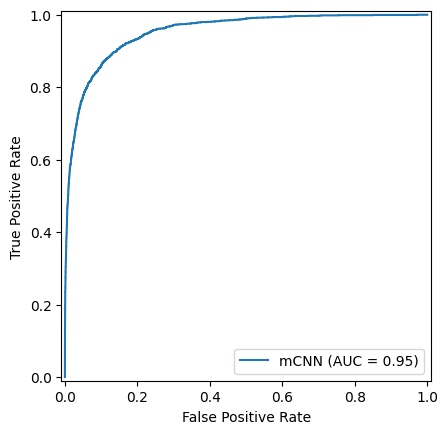

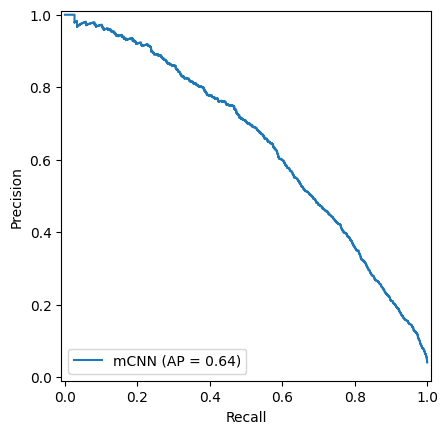

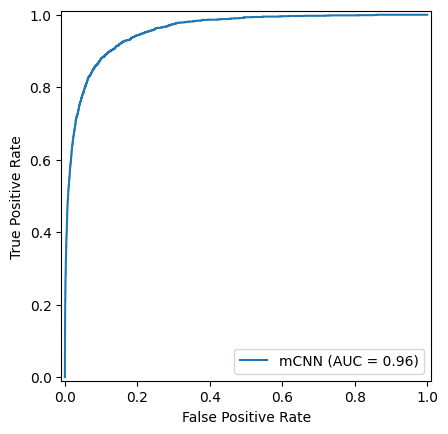

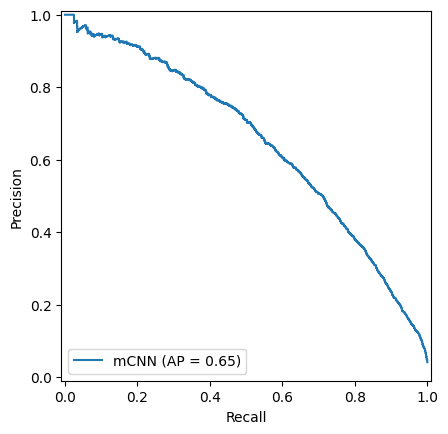

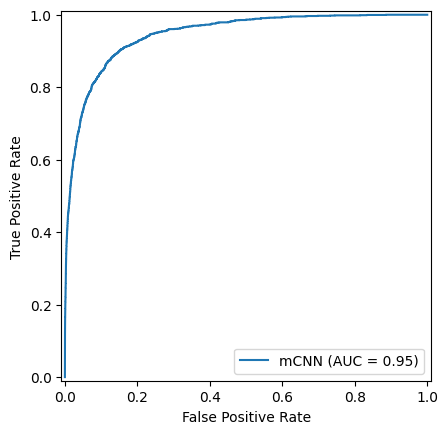

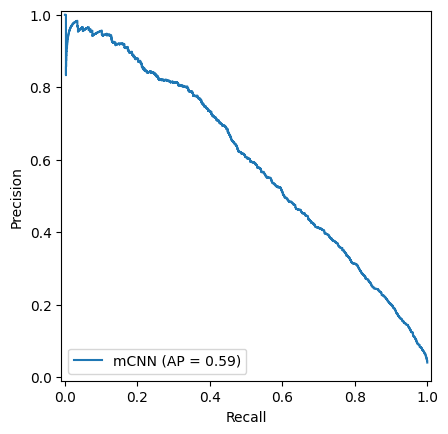

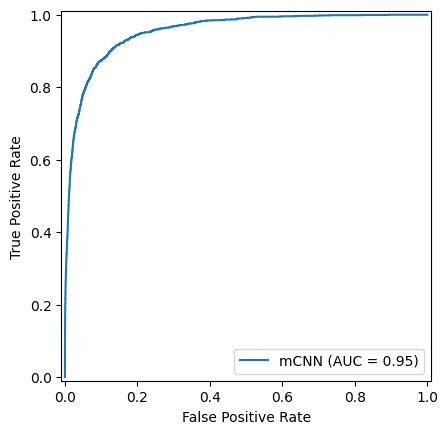

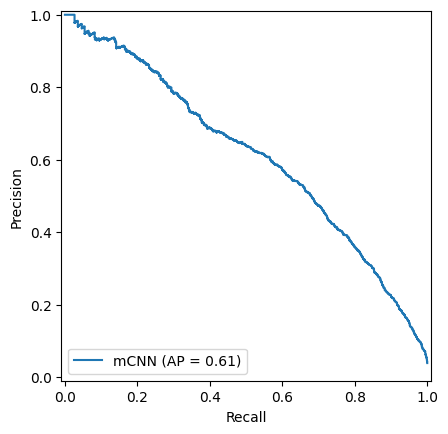

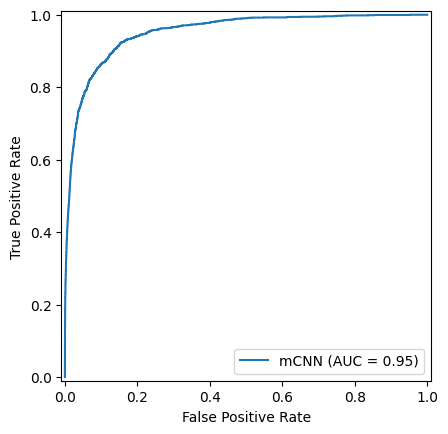

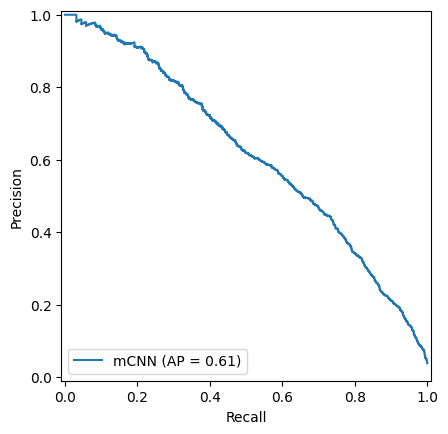

In [7]:
if(VALIDATION_MODE=="cross"):
	time_log("Start cross")
	
	kfold = KFold(n_splits = K_Fold, shuffle = True, random_state = 2)
	results=[]
	i=1
	for train_index, test_index in kfold.split(x_train):
		print(i,"/",K_Fold,'\n')
		# 取得訓練和測試數據
		X_train, X_test = x_train[train_index], x_train[test_index]
		Y_train, Y_test = y_train[train_index], y_train[test_index]
		
		print(X_train.shape)
		print(X_test.shape)
		print(Y_train.shape)
		print(Y_test.shape)
		X_train,Y_train=IMBALANCE_funct(IMBALANCE,X_train,Y_train)
		generator = DataGenerator(X_train, Y_train, batch_size=BATCH_SIZE)
		# 重新建模
        
		model = DeepScan(
		num_filters=NUM_FILTER,
			num_hidden=NUM_HIDDEN,
			window_sizes=WINDOW_SIZES) 
        
        
 
		model.build(input_shape=X_train.shape)
		# 在測試數據上評估模型
		history=model.fit(
			generator,
			epochs=EPOCHS,
			callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)],
			verbose=1,
			shuffle=True
		)
		TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC = model_test(model, X_test, Y_test)
		results.append([TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC])
		i+=1
		
		del X_train
		del X_test
		del Y_train
		del Y_test
		gc.collect()
		
	mean_results = np.mean(results, axis=0)
	print(f'TP={mean_results[0]:.4}, FP={mean_results[1]:.4}, TN={mean_results[2]:.4}, FN={mean_results[3]:.4}, Sens={mean_results[4]:.4}, Spec={mean_results[5]:.4}, Acc={mean_results[6]:.4}, MCC={mean_results[7]:.4}, AUC={mean_results[8]:.4}\n')
	write_data.append(mean_results[0])
	write_data.append(mean_results[1])
	write_data.append(mean_results[2])
	write_data.append(mean_results[3])
	write_data.append(mean_results[4])
	write_data.append(mean_results[5])
	write_data.append(mean_results[6])
	write_data.append(mean_results[7])
	write_data.append(mean_results[8])



In [8]:
if(VALIDATION_MODE=="independent"):
    #x_train,y_train=IMBALANCE_funct(IMBALANCE,x_train,y_train)
    generator = DataGenerator(x_train, y_train, batch_size=BATCH_SIZE)
    model = DeepScan(
    	num_filters=NUM_FILTER,
    	num_hidden=NUM_HIDDEN,
    	window_sizes=WINDOW_SIZES)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.build(input_shape=x_train.shape)
    model.summary()
    model.fit(
    	generator,
    	epochs=EPOCHS,
    	shuffle=True,
    )
    TP,FP,TN,FN,Sens,Spec,Acc,MCC,ROCAUC,F1,Prec,Recall,PRAUC = model_test(model, x_test, y_test)